# Advanced Risk Management – Assignment 1

**Deadline**:  February 20, 13.00h.

| |Name |Student number|Email|

* |Jason Spano  |: ***** |:  *****  |


****Hand in the following via Canvas****:
* Your notebook.
* A (printed) pdf version of your notebook. In Google Colab, this is most conveniently done in the Chrome browser, and then using the **`File` -> `Print`** menu option; you may have to print in landscape mode to make sure that everything appears in the pdf.

****Notes****:
* The assignment is part of the examination, so the usual rules regarding plagiarism and fraud apply.
* Before submitting your work, click on **`Runtime`-> `Restart and run all ...`** and verify that your notebook produces the desired results and does not error.

**Declaration of Originality**: We whose names are given under 1. above declare that these solutions are solely our own work, and that we have not made these solutions available to any other student.

## Introduction
The file `RV_data.xlsx` contains daily data (January 2000 – February 2020, or a sub-period), for a number of international stock market indices, on the open-to-close log-return R (measured as percentage) and the daily realized variance RV (obtained from 5-minute returns).
A list of the included indices is given on the website of the data provider, see
https://realized.oxford-man.ox.ac.uk/data/assets (in the Excel file, the leading '.' has been removed from the symbol; e.g. `FCHI` instead of `.FCHI`). In this assignment, you are asked to estimate, test and compare two GARCH models for one of the indices in terms of their in-sample fit and their out-of-sample forecast quality.

## Question 1: Load and display data
First, install and import the relevant libraries:

In [0]:
#Modules
import os
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

## pip install arch
from arch import arch_model

In [0]:
import math
from datetime import date
from scipy.stats import shapiro, probplot
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch.univariate import ARCH, GARCH
from sklearn.metrics import mean_squared_error

In [0]:
#pre-define an output function to later graph the 3 plots more easily
def ts_plot(residuals, stan_residuals, lags=50):
    
    stan_residuals.plot(title='Line graph of GARCH Standardized Residuals', 
                        figsize=(15, 10))
    
    ## may require importing matplotlib inline
    plt.show()
    
    ## create subplots with 1 row and 2 columns: 
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    ax[0].set_title('GARCH Standardized Residuals KDE')
    ax[1].set_title('GARCH Standardized Resduals Probability Plot')    
    
    #To show the probability density function of the standardized residuals
    stan_residuals.plot(kind='kde', ax=ax[0]) 
    
    #Shows a probability plot of standardized residuals against the quantiles of a normal distribution
    probplot(stan_residuals, 
             dist='norm', 
             plot=ax[1]) 
    
    plt.show()
    
    ## autocorrelation plot
    acf = plot_acf(stan_residuals, lags=lags)
    acf.suptitle('GARCH Model Standardized Residuals Autocorrelation', 
                 fontsize=15)
    
    acf.set_figheight(5)
    acf.set_figwidth(15)
    plt.show()
    
    ## repeat for squared standardised residuals 
    acf2 = plot_acf(residuals, lags=lags)
    acf2.suptitle('GARCH Model Squared Standardized Residuals Autocorrelation', 
                  fontsize=15)
    
    acf2.set_figheight(5)
    acf2.set_figwidth(15)
    plt.show()

Next, import the data and obtain the returns for one chosen index. Uncomment and adapt the lines necessary to mount the drive and change the path.

In [0]:
## read in the excel .xlsx (if file is in the same location as workbook)
df = pd.read_excel('RV_data.xlsx')

## set date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

## set date to index
df = df.set_index(['Date'])

## select a ticker symbol 
sel = df['Symbol']=='AEX'   
 
## loc the Returns column based off the selected ticker    
R = df['R'].loc[sel]

Display a line graph of the returns, and display the autocorrelation function of the returns and of the squared returns. Discuss whether you find the "stylized facts" mentioned in the textbook and slides of the course.

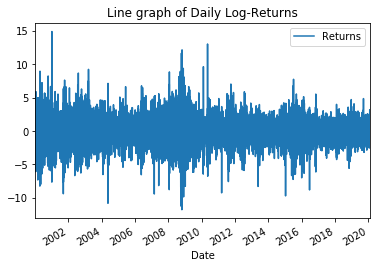

In [8]:
df.plot.line(y='R', label='Returns')
plt.title('Line graph of Daily Log-Returns', fontsize=12)    
plt.show()

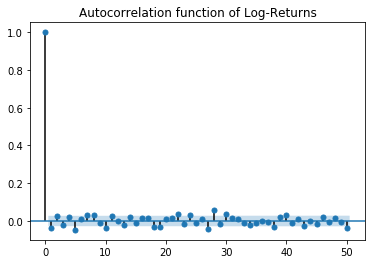

In [9]:
plot_acf(R,lags=50)
plt.title('Autocorrelation function of Log-Returns', fontsize=12)
plt.show()

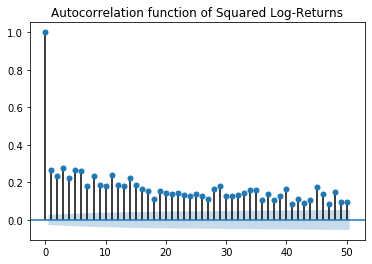

In [10]:
Rsquared = R**2
plot_acf(Rsquared, lags=50)
plt.title('Autocorrelation function of Squared Log-Returns', fontsize=12)
plt.show()

### Discussion of results:
* There are a number of stylized facts for asset returns. One of them can be derived from the first graph, which is volatility clustering. The daily returns do not seem to be random but seem to have clustered values over time. We see that large absolute returns tend to be followed by large absolute returns and vice versa. This is also shown in the third graph where squared daily returns have relatively high positive autocorrelation, espcecially during the first lags.

* A second fact is that daily returns have relatively low autocorrelation and no predictability in mean. This is shown in the second graph where autocorrelation values are very low.

* Another important stylized fact is that (daily) returns have higher kurtosis than the normal distribution and are negatively skewed. This means they are more peaked and have longer tails and thus are non-normal. This fact however cannot be derived from our graphs.

* The mean blur, leverage effect and time-varying correlations are the other three stylized facts but these cannot be derived from our graphs.


## Question 2: Fitting a symmetric GARCH model
Estimate and test a GARCH model for the returns, using only data over the sub-period January 2000 – December 2012. For this question, do **not** consider a GJR-GARCH model or any model with an asymmetric NIC (see next question), but focus on standard GARCH($p,q$) models. Display and discuss the estimation output, and test the model for the absence of volatility clustering in the standardized residuals (shocks) $\hat{z}_t$. If you try out various GARCH models, only report discuss the results on the final model.

Note: estimation over a sub-sample using the ARCH package can be done by specifying `last_obs =` in the `.fit` function; see https://arch.readthedocs.io.

In [11]:
### Estimating of the standard symmetric GARCH model

## set index to the same index used by the returns series
index = R.index

## drop any missing values
returns = R.dropna()

## initialise thE GARCH model instance on the NaN Dropped Returns series, distribution == normal 
am_2 = arch_model(returns, vol='Garch',p=1,o=0,q=1, dist='Normal')

## the last observation date
res1 = am_2.fit(last_obs='2012-12-31')

## print the summary which includes steps to optimisation value / iterations 
print(res1.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4725.046087455656
Iteration:      2,   Func. Count:     16,   Neg. LLF: 4717.62473123438
Iteration:      3,   Func. Count:     24,   Neg. LLF: 4713.185680755121
Iteration:      4,   Func. Count:     32,   Neg. LLF: 4712.248333761487
Iteration:      5,   Func. Count:     39,   Neg. LLF: 4703.584407995852
Iteration:      6,   Func. Count:     46,   Neg. LLF: 4702.092536668209
Iteration:      7,   Func. Count:     53,   Neg. LLF: 4698.829004081826
Iteration:      8,   Func. Count:     60,   Neg. LLF: 4698.520617138741
Iteration:      9,   Func. Count:     67,   Neg. LLF: 4698.389445651215
Iteration:     10,   Func. Count:     73,   Neg. LLF: 4698.385062719118
Iteration:     11,   Func. Count:     79,   Neg. LLF: 4698.385055875802
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4698.385055876145
            Iterations: 11
            Function evaluations: 79
            Gradient evaluations: 11

In [0]:
#define parameters
resi = res1.resid                  #model residuals
hsq = res1.conditional_volatility  #square root of conditional variance
sres = resi/hsq                    #standardized residuals
Zt = R / hsq                       #standardised returns 

In [0]:
model_1_LLF = res1.loglikelihood

In [0]:
#drops any data out of the chosen sample period
model1_zt = Zt.dropna()
model1_resi = resi.dropna()
model1_hsq = hsq.dropna()
model1_sres = sres.dropna()
model1_sressq = model1_sres**2

#### call the graphing function defined at the top of this workbook
* called "ts_plot"

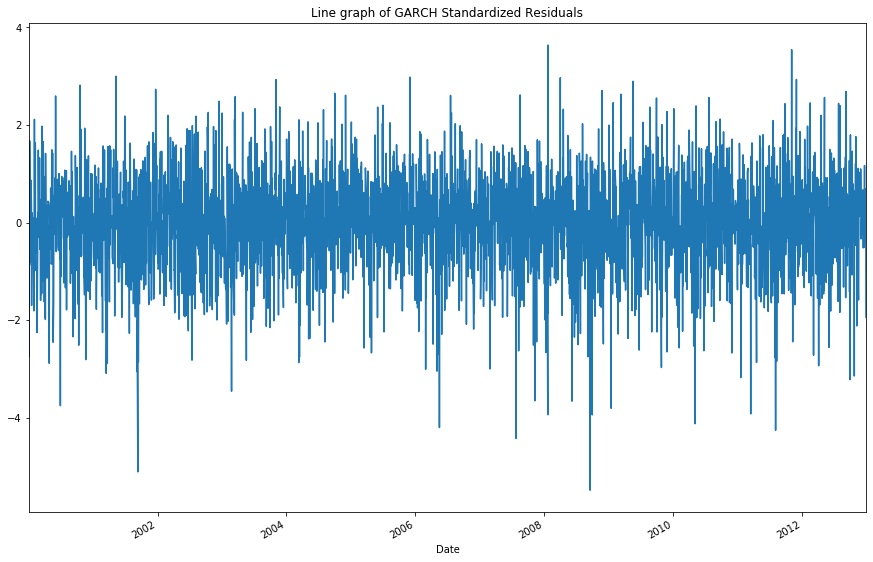

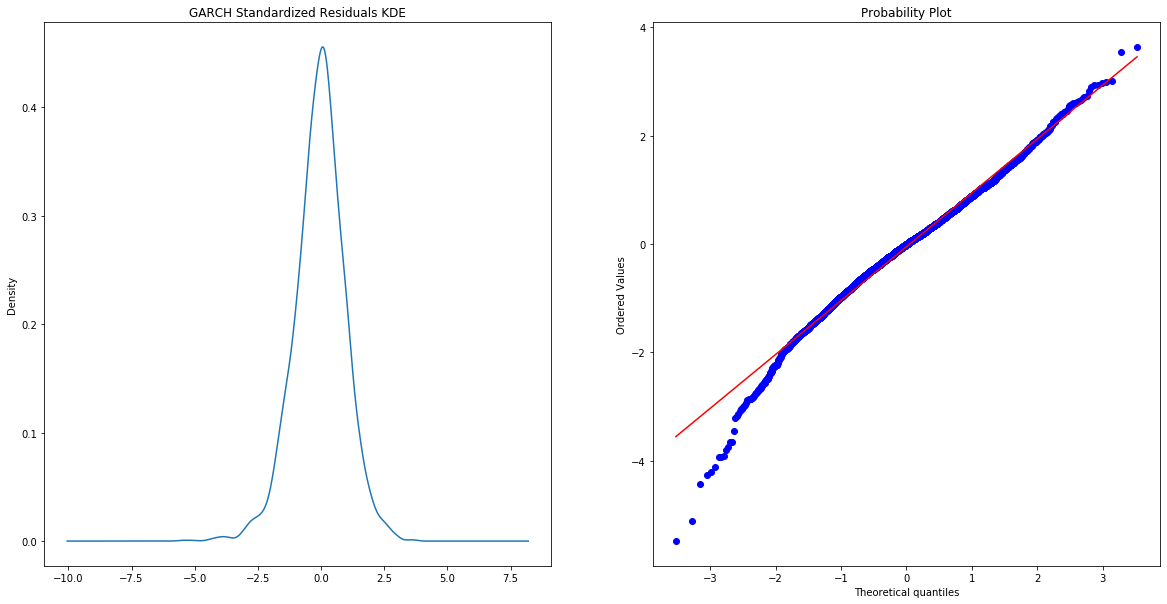

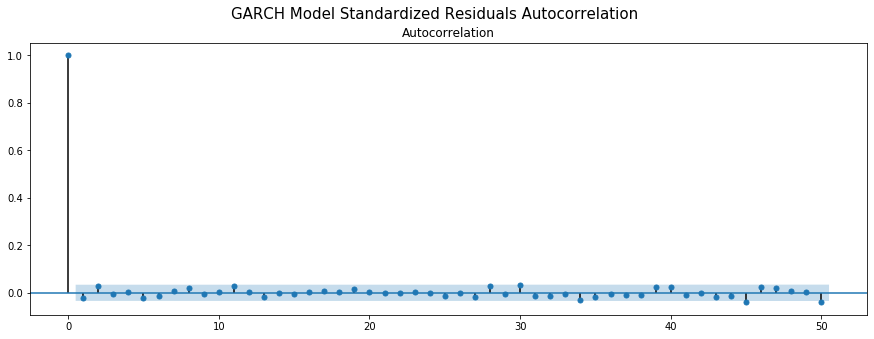

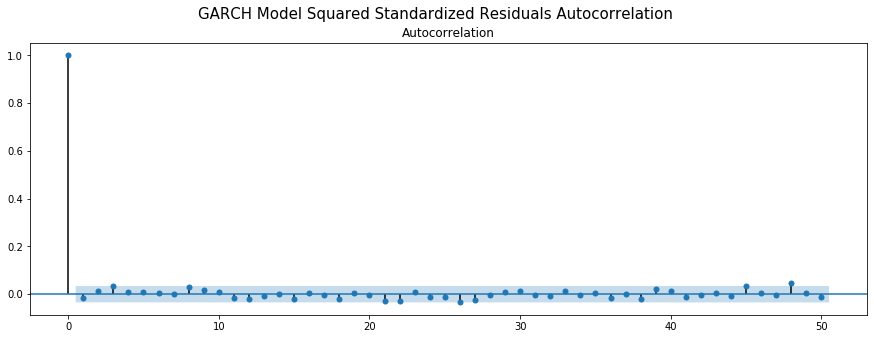

In [15]:
#statistical functions 
ts_plot(model1_sressq, model1_sres)
arch_test = het_arch(model1_sressq, maxlag=50) #Engle's test for heteroskedasticity in the standardised residuals
shapiro_test = shapiro(model1_sres)            #Shapiro-Wilk Test / normality of the standardised residuals

In [16]:
#statistical functions for model selection 
print(f'F test p-value(arch_test): {arch_test[3]}')
print(f'Shapiro-Wilks p-value: {shapiro_test[1]}')

Lagrange mulitplier p-value(arch_test): 0.6513430492133535
F test p-value(arch_test): 0.6536747230567738
Shapiro-Wilks p-value: 2.746271132713778e-16


In [17]:
#statistical functions / Ljung-Box test of autocorrelation in residuals.
print("To test for autocorrelation in the squared standardized residuals")
ljung_sressq = acorr_ljungbox(model1_sressq, lags= 30, boxpierce=True)
print(f'Ljung-Box p-values: {ljung_sressq[1]}')
print(f'\nBox-Pierce p-values: {ljung_sressq[3]}')

To test for autocorrelation in the squared standardized residuals
Ljung-Box p-values: [0.40834956 0.55303347 0.16939238 0.2503503  0.34808593 0.45362937
 0.57109735 0.38016129 0.40203635 0.47633427 0.47616371 0.45792826
 0.51606453 0.59404677 0.57836617 0.64621028 0.70891031 0.67107516
 0.7256253  0.7778491  0.67335845 0.55479731 0.5917276  0.61201258
 0.63461227 0.46930594 0.4211486  0.47158091 0.51426021 0.53067893]

Box-Pierce p-values: [0.40856178 0.55337193 0.16990109 0.25105024 0.34895693 0.45461732
 0.57210374 0.38169886 0.40377693 0.47820052 0.4782826  0.46034418
 0.51859319 0.59654045 0.5812195  0.64896529 0.71148815 0.67424004
 0.72859132 0.78052766 0.67743535 0.56016039 0.59714346 0.61757861
 0.64028305 0.47655153 0.42887137 0.47949465 0.52229087 0.5389538 ]


In [18]:
print("To test whether autocorrelation in the squared standardized residuals is significantly different from zero")
ljung_res_ar = np.array(ljung_sressq)
ljung_res_ar <= 0.05

To test whether autocorrelation in the squared standardized residuals is significantly different from zero


array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]])

In [19]:
print(
"""ljung-box test: test is:\
If  p < α  (0.05) we reject the null hypothesis of no auto-correlation between each of its lags at the 95% CL

Otherwise expressed:
Ho: The data are independently distributed, no autocorrelation.\ 
Ha: The data are not independently distributed; they exhibit serial correlation.""")

ljung-box test: test is:If  p < α  (0.05) we reject the null hypothesis of no auto-correlation between each of its lags at the 95% CL

Otherwise expressed:
Ho: The data are independently distributed, no autocorrelation.\ 
Ha: The data are not independently distributed; they exhibit serial correlation.


In [20]:
if np.any(ljung_res_ar <= 0.05):
    print("Reject the null(there is auto-correlation)")
else:
    print("Cannot reject the null of no auto-correlation between series an each of its lags at 95% confidence level\
    that is, no autocorrelation detected")

Cannot reject the null of no auto-correlation between series an each of its lags at 95% confidence level    that is, no autocorrelation detected


### Discussion of results:

* The model generates significantly positive results for all variables. This means that every unit increase in return increases now variance in the next period by 0.1055 and every unit increase in variance now increases variance in the next period with 0.8878.

* The line graph of the standardized residuals (SR) shows their values are divided quite evenly over time and shows little sign of volatility clustering. The autocorrelation functions of the SR and squared SR show that the autocorrelations of both are relatively low, as it should be when there is no volatility clustering. The Ljung-Box and Box-Pierce values show that the autocorrelation of the SRs is not significantly different from zero.

* From the KDE graph it seems that the SRs have a distribution with a high peak and thin tails. This could be an indication of a non-normal distribution. With the Shapiro-test we test for normality. The p-value is 2.75e-16, meaning that the distribution of the SRs is significantly different from a normal distribution. In conclusion, given the nature of the asymmetric model; it is expected to invalidate the shapiro-wilk test by default. The final ljung-box test reaffirms the lack of volatility clustering in the squared SRs which can be visually confirmed with the ACF plot.

## Question 3: Fitting an asymmetric GARCH model
(a) Extend the model you obtained above with one or more asymmetric terms (leading to a GJR-GARCH model), and estimate this second model using data over the same sub-period. Analogously to Question 2, display and discuss the estimation output, and test for volatility clustering in $\hat{z}_t$.

In [21]:
#Estimating a GJR-GARCH model:
index = R.index
returns = R.dropna()   
am_2 = arch_model(returns, vol='Garch',p=1,o=1,q=1)
res2 = am_2.fit(last_obs='2012-12-31')
print(res2.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 4647.738718984186
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4647.625420665267
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4647.086398519826
Iteration:      4,   Func. Count:     36,   Neg. LLF: 4643.764963964767
Iteration:      5,   Func. Count:     44,   Neg. LLF: 4639.577942485128
Iteration:      6,   Func. Count:     52,   Neg. LLF: 4637.69902947297
Iteration:      7,   Func. Count:     60,   Neg. LLF: 4634.921399966093
Iteration:      8,   Func. Count:     67,   Neg. LLF: 4634.1762021243285
Iteration:      9,   Func. Count:     74,   Neg. LLF: 4633.075167911845
Iteration:     10,   Func. Count:     82,   Neg. LLF: 4632.692908780818
Iteration:     11,   Func. Count:     89,   Neg. LLF: 4632.371161583704
Iteration:     12,   Func. Count:     96,   Neg. LLF: 4632.363201970469
Iteration:     13,   Func. Count:    103,   Neg. LLF: 4632.362810327551
Iteration:     14,   Func. Count:    110,   Neg. LLF: 4632.36280

In [0]:
resi = res2.resid                  #model residuals
hsq = res2.conditional_volatility  #square root of conditional variance
sres = resi/hsq                    #standardised residuals
Zt = R / hsq                       #standardised returns 

In [0]:
model2_zt = Zt.dropna()
model2_resi = resi.dropna()
model2_hsq = hsq.dropna()
model2_sres = sres.dropna()
model2_sressq = model2_sres**2

In [0]:
model_2_LLF = res2.loglikelihood

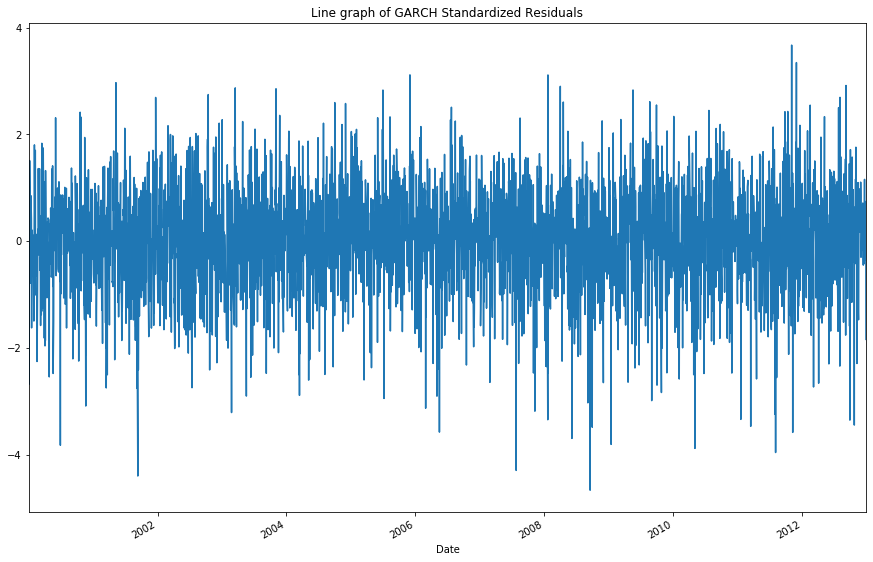

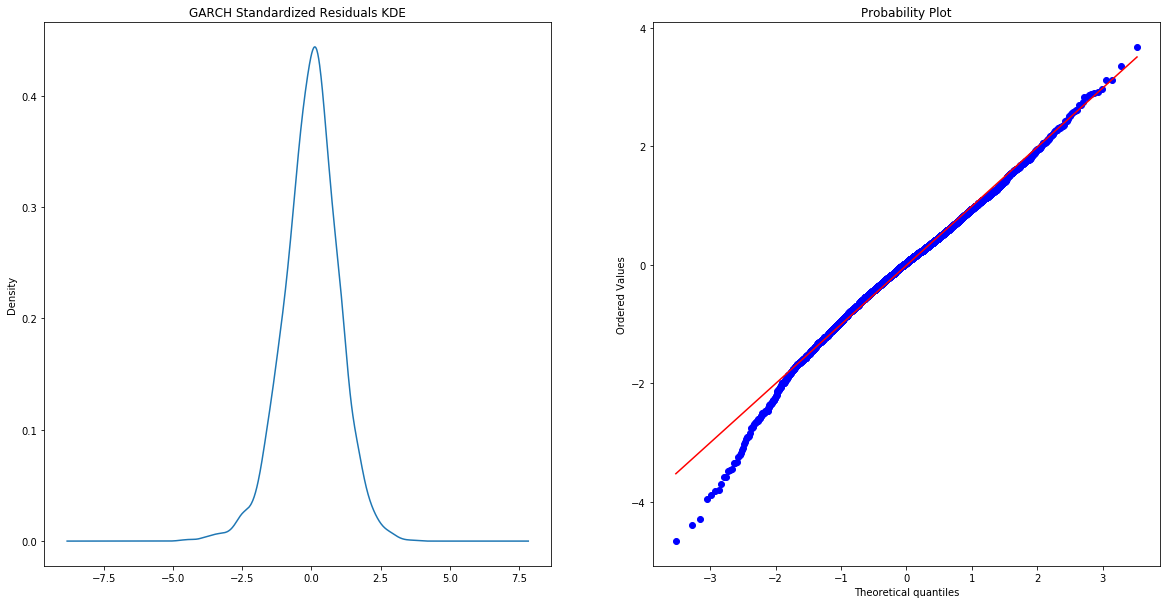

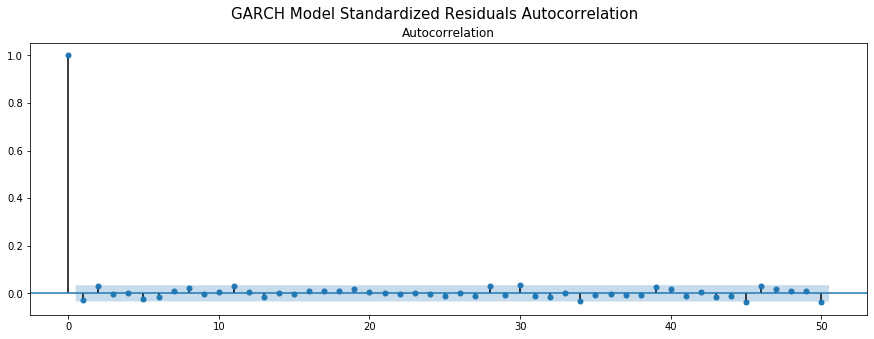

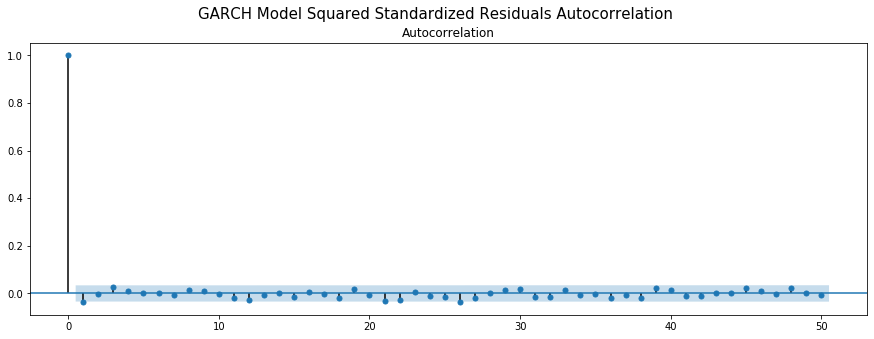

In [25]:
#statistical functions & graphs
ts_plot(model2_sressq, model2_sres)
arch_test = het_arch(model2_sressq, maxlag=50) #Engle's test for heteroskedasticity in the standardised residuals
shapiro_test = shapiro(model2_sres)            #Shapiro-Wilk Test / normality of the standardised residuals

In [26]:
print(f'F test p-value: {arch_test[3]}')
print(f'Shapiro-Wilks p-value: {shapiro_test[1]}')

Lagrange mulitplier p-value: 0.9710781952189249
F test p-value: 0.9720079462473528
Shapiro-Wilks p-value: 1.4875459804913893e-13


In [27]:
#statistical functions / Ljung-Box test of autocorrelation in residuals.
print("To test for autocorrelation in the squared standardized residuals")
ljung_sressq = acorr_ljungbox(model2_sressq, lags= 30, boxpierce=True)
print(f'Ljung-Box p-values: {ljung_sressq[1]}')
print(f'\nBox-Pierce p-values: {ljung_sressq[3]}')

To test for autocorrelation in the squared standardized residuals
Ljung-Box p-values: [0.04849861 0.14216079 0.08433642 0.13638225 0.21916103 0.31899269
 0.41211116 0.44837966 0.51278186 0.60182615 0.59691295 0.43143857
 0.50401464 0.58062748 0.58289495 0.64109876 0.70691065 0.6782168
 0.67716657 0.73025363 0.60121888 0.52568593 0.57836163 0.61632807
 0.63593046 0.42142028 0.4045218  0.45674032 0.47304784 0.47694348]

Box-Pierce p-values: [0.04860047 0.14241226 0.08462186 0.13682305 0.21978021 0.31976352
 0.41300139 0.44945697 0.51397736 0.60302113 0.59840186 0.43369084
 0.50635798 0.58295949 0.58550847 0.64367804 0.70930974 0.68113238
 0.68038576 0.73326501 0.60570221 0.53099591 0.58365179 0.62162728
 0.64136829 0.42859145 0.41205244 0.46449163 0.48108763 0.48532995]


In [28]:
print("To test whether autocorrelation in the squared standardized residuals is significantly different from zero")
ljung_res_ar = np.array(ljung_sressq)
ljung_res_ar <= 0.05

To test whether autocorrelation in the squared standardized residuals is significantly different from zero


array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False],
       [ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False],
       [ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]])

In [29]:
print(
"""ljung-box test: test is:\
If  p < α  (0.05) we reject the null hypothesis of no auto-correlation between each of its lags at the 95% CL

Otherwise expressed:
Ho: The data are independently distributed, no autocorrelation.\ 
Ha: The data are not independently distributed; they exhibit serial correlation.""")

ljung-box test: test is:If  p < α  (0.05) we reject the null hypothesis of no auto-correlation between each of its lags at the 95% CL

Otherwise expressed:
Ho: The data are independently distributed, no autocorrelation.\ 
Ha: The data are not independently distributed; they exhibit serial correlation.


In [30]:
if (np.count_nonzero(ljung_res_ar <= 0.05) <=3):
    print("Cannot reject the null of no auto-correlation at the 95% confidence level; allowing for a small number of significant lags per chance")
elif (np.count_nonzero(ljung_res_ar <= 0.05) >3):
    print("Reject the null-- there is auto-correlation")

Cannot reject the null of no auto-correlation at the 95% confidence level; allowing for a small number of significant lags per chance


### Discussion of results:

* The model generates significantly positive results for all variables except alpha. This means that there is not significant effect of return now on variance in the next period and every unit increase in variance now increases variance in the next period by 0.9148. In this model we added gamma that takes care of the leverage effect caused by negative returns. The coefficient tells us that for every unit change increase in negative returns now, variance in the next period increases by 0.1464.

* We can conclude that the type of model makes a notable difference in the coefficients. When the leverage effect (gamma) is included, the effect of squared returns (alpha) becomes insignificant. This might be because the squared returns and the dummy of negative returns are correlated so that the dummy will take part of the effect of squared returns and leave it insignificant.

* We see that the type of model does not make much difference for the charachteristics of the SRs of both models. The line graph of the SRs still shows their values are divided quite evenly over time and shows little sign of volatility clustering. The autocorrelation function of the SR shows that the autocorrelation is relatively low, as it should be when there is no volatility clustering. The Ljung-Box and Box-Pierce values show that the autocorrelation of the standardized residuals is not significantly different from zero.

* From the KDE graph it seems that the standardized rediduals have a  distribution with a high peak and thin tails. With the Shapiro-test we test for normality. The p-value is 1.49e-13, meaning that the distribution of the standardized residuals is significantly different form a normal distribution.


(b) Carry out a likelihood ratio test for the symmetric model of Question 2 (the null hypothesis) against the asymmetric model of Question 3 (the alternative hypothesis). Obtain the p-value of the test from the `scipy.stats` library.

In [31]:
print(model_1_LLF, model_2_LLF)

-4698.385055876145 -4632.362807524163


In [32]:
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)


## likelihood ratio tests of the two models
def lrtest(model_1_LLF, model_2_LLF):
    lr = 2 * (model_1_LLF - model_2_LLF)
    p = stats.chisqprob(lr, 1)
    return lr, p

lr, p = lrtest(model_1_LLF, model_2_LLF)

## print the LR ratio + associated p_value 
print('LR test, p value: {:.2f}, {:.4f}'.format(lr, p)) 

LR test, p value: -132.04, 1.0000


### Discussion of results:
* The null hypothesis for a likelihood ratio test is that the smaller/nested (less predictors) model is the “better” model. This is rejected for a p-value smaller than 0.05 (for a 95% confidence interval). 
* Our p-value shows up as 1.0, so we fail to reject the Null hypothesis. This test thus indicates that the asymmetric GJR-GARCH model does not significantly fit better than the symmetrical GARCH model.

## Question 4: Comparing the out-of-sample fit
From the two models estimated above, obtain the out-of-sample (one-step-ahead) conditional variance predictions over the period January 2013 – February 2020. These are based on coefficient estimates from data until 2012, but they use the most recent returns $R_t$ to obtain the predictions for $\sigma_{t+1}^2$ in the period after 2012 (consult the ARCH package documentation for details).

(a) Make a new data-frame containing the two sets of variance predictions, as wel as the realized variance for the same index and over the same sub-period (January 2013 – February 2020). Make a plot of the two predicted volatility series (square root of the predicted variances) in one figure, and discuss similarities and differences.

In [33]:
#forecasts model one
model1_forecast = res1.forecast(horizon=1)
print(model1_forecast.variance.dropna().tail(5))

                 h.1
Date                
2020-02-04  0.739857
2020-02-05  0.901159
2020-02-06  0.819145
2020-02-07  0.743688
2020-02-10  0.674370


In [34]:
model2_forecast = res2.forecast(horizon=1)
print(model2_forecast.variance.dropna().tail(5))

                 h.1
Date                
2020-02-04  0.578372
2020-02-05  0.542393
2020-02-06  0.509479
2020-02-07  0.481808
2020-02-10  0.454058


In [35]:
trim_model1_forecast = model1_forecast.variance.dropna()
print(len(trim_model1_forecast))
print(len(model1_forecast.variance))

1814
5125


In [36]:
#repeat for model2
trim_model2_forecast = model2_forecast.variance.dropna()
print(len(trim_model2_forecast))
print(len(model2_forecast.variance))

1814
5125


In [37]:
#concatenate trimmed series 
df_forecasts = pd.concat([trim_model1_forecast, trim_model2_forecast],axis=1)
df_forecasts.columns = ['Model1_forecast','Model2_forecast']
df_forecasts.tail(2)

,Model1_forecast,Model2_forecast
Date,,
2020-02-07,0.743688,0.481808
2020-02-10,0.674370,0.454058


In [38]:
df_fcast = df_forecasts.drop(df_forecasts.index[:2])
df_fcast.head(2)
#check if start of series match

,Model1_forecast,Model2_forecast
Date,,
2013-01-02,0.357123,0.344782
2013-01-03,0.331421,0.328710


In [39]:
df_excel = pd.read_excel('RV_data.xlsx')
df_excel['Date'] = pd.to_datetime(df_excel['Date'], format='%Y%m%d')
df_excel = df_excel.set_index(['Date'])
sel = df['Symbol']=='AEX'   # Boolean array to select index;
      
## RV = realised variance 
RV_series = df['RV'].loc[sel]
RV_trim = RV_series.loc['2013-1-1':]
RV_trim.head(2) #match the length of the RV series with that of the forecast period

Date
2013-01-02    0.382839
2013-01-03    0.197959
Name: RV, dtype: float64

In [40]:
#Final DF comparison of 2 models forecasted variance Vs. Realised Variance 
df_forecast = pd.concat([df_fcast,RV_trim],axis=1)
df_forecast.head()

,Model1_forecast,Model2_forecast,RV
Date,,,
2013-01-02,0.357123,0.344782,0.382839
2013-01-03,0.331421,0.328710,0.197959
2013-01-04,0.317906,0.314007,0.147157
2013-01-07,0.300430,0.304961,0.164677
2013-01-08,0.288171,0.300533,0.165594


## PLOT SQUARE ROOT OF THE PREDICTED VARIANCES OVER TIME 

No handles with labels found to put in legend.


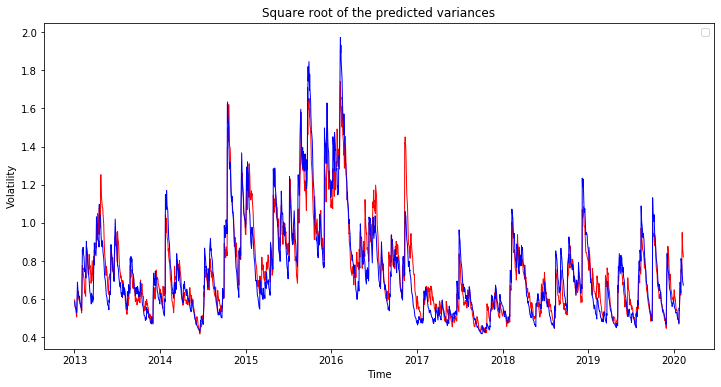

In [41]:
sqrt_m1fc = np.sqrt(df_forecast['Model1_forecast'])
sqrt_m2fc = np.sqrt(df_forecast['Model2_forecast'])
plt.figure(figsize=(12,6))
plt.plot(sqrt_m1fc,'r',markersize=6, linewidth=1)
plt.plot(sqrt_m2fc,'b',markersize=3, linewidth=1)
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.title("Square root of the predicted variances")
plt.legend()
plt.show()

### Discussion of results:
The two models are quite similiar - which is somewhat expected given the degree of similarities in the GARCH specifications.
However, model_one tends to have more instances of deviating significantly from model_two - at the highs particularly.
For example, in early 2013, mid-2016 and in particular, early 2017. 

Moreover, using salient examples of: early 2015 and mid-2016, model_one tends to consistently estimate volatiity above model_two
in mid-2016, model_one's predicted volatiltiy stays above model_2 for a significant period of time

(b) Calculate the mean squared error of the two variance predictions (using the realized variance as the true $\sigma_{t+1}^2$), and discuss the result; which one of the two models gives the best predictions?

In [42]:
#model 1 - MSE 
y_true = df_forecast['Model1_forecast']
y_pred = df_forecast['RV']
model1_MSE = mean_squared_error(y_true,y_pred)
model1_MSE

0.5371004101841075

In [43]:
#model 2
y_true = df_forecast['Model2_forecast']
y_pred = df_forecast['RV']
model2_MSE = mean_squared_error(y_true,y_pred)
model2_MSE

0.5168093373433846

In [44]:
MSE_difference = model1_MSE - model2_MSE
MSE_difference

0.020291072840722846

### Discussion of results:
* Even though the difference is relatively small, the GJR-GARCH model shows a lower mean squared error compared to the standard GARCH model. This means that the GJR-GARCH model should have better predictive power; also iterated as this model has a less-biased estimate of the error variance.

(c) As discussed in Sections 4.6.3 and 5.7 of the book, variance forecasts $\hat{\sigma}_{t+1}^2$ can be evaluated in the linear regression

$RV_{t+1} = b_0 + b_1\hat{\sigma}_{t+1}^2 + e_{t+1}$,

by testing the two restrictions $b_0=0, b_1=1$ (separately and jointly).
Estimate this regression twice: first, using the symmetric GARCH model prediction (Question 2), and next, using the asymmetric GARCH model prediction (Question 3) as explanatory variable. Report the estimation results and the outcome of the $F$-test for $b_0=0, b_1=1$ (use heteroskedasticity-robust standard errors). What do you conclude?

In [45]:
y_true = df_forecast['Model1_forecast']
y_pred = df_forecast['RV']        
y_true = sm.add_constant(y_true)
m1_reg1 = sm.OLS(y_pred, y_true)
mod_1_results = m1_reg1.fit(covtype='HAC')
print(mod_1_results.summary())

                            OLS Regression Results                            
Dep. Variable:                     RV   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     681.9
Date:                Wed, 19 Feb 2020   Prob (F-statistic):          7.70e-128
Time:                        21:43:45   Log-Likelihood:                -2003.6
No. Observations:                1812   AIC:                             4011.
Df Residuals:                    1810   BIC:                             4022.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0665      0.030     

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [46]:
#note: the F-test will be equivalent to the squared t-stat (F-test relative to the number of K in the model)
print(mod_1_results.f_test("Model1_forecast=1"))

<F test: F=array([[0.47694002]]), p=0.4899001889613781, df_denom=1.81e+03, df_num=1>


In [47]:
print(mod_1_results.f_test("const=0"))
#note: this test is equivalent to squared t-stat

<F test: F=array([[4.97905155]]), p=0.025778084735093118, df_denom=1.81e+03, df_num=1>


In [48]:
print(mod_1_results.f_test("Model1_forecast=1, const=0"))

<F test: F=array([[4.42250529]]), p=0.012134112987085034, df_denom=1.81e+03, df_num=2>


In [49]:
#model 2: 
y_true = df_forecast['Model2_forecast']
y_pred = df_forecast['RV']
y_true = sm.add_constant(y_true)
reg2 = sm.OLS(y_pred, y_true)
mod_2_results = reg2.fit(covtype='HAC')
print(mod_2_results.summary())

                            OLS Regression Results                            
Dep. Variable:                     RV   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     782.5
Date:                Wed, 19 Feb 2020   Prob (F-statistic):          2.09e-143
Time:                        21:43:46   Log-Likelihood:                -1967.7
No. Observations:                1812   AIC:                             3939.
Df Residuals:                    1810   BIC:                             3950.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0175      0.027     

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [50]:
print(mod_2_results.f_test("Model2_forecast=1"))

<F test: F=array([[2.25806108]]), p=0.1330948307736489, df_denom=1.81e+03, df_num=1>


In [51]:
print(mod_2_results.f_test("const=0"))

<F test: F=array([[0.42229122]]), p=0.515878442951142, df_denom=1.81e+03, df_num=1>


In [52]:
print(mod_2_results.f_test("Model2_forecast=1, const=0"))

<F test: F=array([[5.36697421]]), p=0.004742822718393386, df_denom=1.81e+03, df_num=2>


## Discussion of results:
* For model 1, the the predicted variance is significantly equal to 1, though the constant is significantly different from 0. For model 2 both the predicted variance and constant are significantly equal to 1 and 0, respectively. Both models are, surprisingly for model 2, jointly significantly unequal to 1 for the forecast coefficient and 0 for the constant. This makes it difficult to decide which model would have better predictive power, but as model two has both coefficients seperately significantly equal to 0 and 1 respectively, we would prefer model 2 over model 1 as a predictive model of future variance.